# real time transfer와의 차이점
* batch norm --> instance norm ( style factor(gamma, beta) 사용)
* zero padding --> mirror padding
* deconv --> nearest neighbor upsampling and conv


### import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
import os, time

### parameters

In [2]:
IMAGE_H = 256
IMAGE_W = 256

E_W = [1,1,1,1,1]
ALPHA = 1
BETA = 5
GAMMA = 1e-6

COCO_PATH = '/home/minsisi/COCO_DATASET/train2014/'
BATCH_SIZE = 2
DATA_NUM = 12000
EPOCH = 2
LR = 1e-3

### new function for multi style transfer

In [3]:
def mirror_padding(img, kernel):
    n = img.get_shape().as_list()[2] # Height of image
    
    pad_size = (kernel-1)/2
    
    a=b=pad_size
    
    paddings = np.array([[0,0], [a,a], [b,b],[0,0]] ,dtype=np.int32)
    
    return tf.pad(img, paddings, mode="SYMMETRIC",name='pad')
            

In [4]:
def instance_norm(x,epsilon=1e-3):
    mu, sig_sq = tf.nn.moments(x,axes=[1,2],  keep_dims=True)
    ch = x.get_shape().as_list()[-1]
    
    scale = tf.Variable(tf.ones(ch))
    offset = tf.Variable(tf.zeros(ch))
    
    return ((x-mu)/tf.sqrt(sig_sq+epsilon))*scale + offset

In [5]:
def upsampling_block(inp, st, kn,ch, relu=True, pad='zero'):
    inp_ch = inp.get_shape()[3].value
    w = weight_tensor([kn, kn, inp_ch, ch])
    inp_shape = inp.get_shape().as_list()
    ## image resize by nearest neighbor
    new_size = [int(inp_shape[1]*2), int(inp_shape[2]*2)]
    inp = tf.image.resize_images(inp, new_size,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    ## convolution
    if pad == 'zero':
        padding = 'SAME'
    elif pad == 'mirror':
        inp = mirror_padding(inp, kn)
        padding = 'VALID'
        
    h = tf.nn.conv2d(inp,w, strides=[1, st, st, 1], padding=padding)
    
    ## normalize
    # batch normalization
    # h = tf.contrib.layers.batch_norm(h, data_format='NHWC', center=True, scale=True,is_training=True)

    # instance norm
    h = instance_norm(h)
    
    ## relu
    if relu:
        h = tf.nn.relu(h)
        
    return h

In [6]:
def conv_block(inp, st, kn, ch,  relu=True, pad ='zero'):
    inp_ch = inp.get_shape()[3].value
    w = weight_tensor([kn, kn, inp_ch, ch])
    
    ## convolution
    if pad == 'zero':
        padding = 'SAME'
    elif pad == 'mirror':
        inp = mirror_padding(inp, kn)
        padding = 'VALID'
        
    h = tf.nn.conv2d(inp,w, strides=[1, st, st, 1], padding=padding)
    
    ## normalize
    # batch normalization
    # h = tf.contrib.layers.batch_norm(h, data_format='NHWC', center=True, scale=True,is_training=True)
    
    # instance norm
    h = instance_norm(h)
    
    ## relu
    if relu:
        h = tf.nn.relu(h)
        
    return h


In [7]:
# transform net func
def weight_tensor(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))

def bias_tensor(shape):
    return tf.Variable(tf.zeros(shape))

In [8]:
def residual_blcok(inp, st, kn, ch):
    h = conv_block(inp, st, kn, ch, pad = 'mirror')
    h = conv_block(h, st, kn, ch, relu=False, pad = 'mirror')
    return h+inp

def deconv_block(inp, st, kn, ch, relu=True ):
    bs = tf.shape(inp)[0] #batch size
    inp_shape = inp.get_shape().as_list()
    w =  weight_tensor([kn, kn, ch, inp_shape[3]])    # shape k,k, out_size, input_size

    # deconvolution
    out_shape = tf.stack([bs, int(inp_shape[1]*st), int(inp_shape[2]*st), ch])
    stride_shape = [1, st, st, 1]
    h = tf.nn.conv2d_transpose(inp, w, output_shape=out_shape, strides=stride_shape, padding='SAME')
    h = tf.reshape(h, shape=out_shape)

    # batch norm
    # h = tf.contrib.layers.batch_norm(h, data_format='NHWC', center=True, scale=True,is_training=True)

    # instance norm
    h = instance_norm(h)
    # relu
    if relu:
        h = tf.nn.relu(h)
    return h

### for image 

In [9]:
# # for image process
def visualize_img(x):
    return np.clip(x, 0, 255).astype('uint8')

def read_img(img_path):
    img = misc.imread(img_path)
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    
    return misc.imresize(img, (IMAGE_H,IMAGE_W,3))


### for vgg net

In [10]:
# for vgg network
def conv2d(x, W):
        return tf.nn.conv2d(x,W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### tensor preprocess

In [11]:
# mean value 
def tf_rev_prosess(out_img):
    return tf.stack([ out_img[:,:,:,0] + 103.939, out_img[:,:,:,1] + 116.779,out_img[:,:,:,2] + 123.68], axis=3)
#     return tf.stack([ out_img[:,:,:,2] - 103.939 ,  out_img[:,:,:,1] - 116.779,out_img[:,:,:,0] -  123.68], axis=3)

def tf_preprocess(out_img):
    return tf.stack([ out_img[:,:,:,0] - 103.939, out_img[:,:,:,1] - 116.779,out_img[:,:,:,2] - 123.68 ], axis=3)
#     return tf.stack([ out_img[:,:,:,2] - 123.68 ,  out_img[:,:,:,1] - 116.779,out_img[:,:,:,0] - 103.939], axis=3)

### transform net

In [12]:
# transform net
inp_imgs = tf.placeholder(shape=[None, IMAGE_H, IMAGE_W, 3], dtype= tf.float32) # order BGR, subtracted means

trans_inp = inp_imgs/255
conv1 = conv_block(trans_inp, 1, 9, 32, pad = 'mirror')
conv2 = conv_block(conv1, 2, 3, 64, pad = 'mirror')
conv3 = conv_block(conv2, 2, 3, 128, pad = 'mirror')

rconv1 =  residual_blcok(conv3, 1, 3, 128)
rconv2 =  residual_blcok(rconv1, 1, 3, 128)
rconv3 =  residual_blcok(rconv2, 1, 3, 128)
rconv4 =  residual_blcok(rconv3, 1, 3, 128)
rconv5 =  residual_blcok(rconv4, 1, 3, 128)

# dconv1 = deconv_block(rconv5, 2, 3, 64) 
# dconv2 = deconv_block(dconv1, 2, 3, 32)
# dconv3 = conv_block(dconv2, 1, 9, 3, relu=False, pad='mirror')

## use image resize upsampling
upconv1 = upsampling_block(rconv5, 1, 3, 64,pad='mirror')
upconv2 = upsampling_block(upconv1, 1, 3, 32,pad='mirror')
dconv3 = conv_block(upconv2, 1, 9, 3, relu=False, pad='mirror')

transform_out_img = tf.nn.tanh(dconv3) * 150 + 255./2

### vgg net

In [13]:
# load vgg weights
vggW = np.load('vgg19_weights.npy')
W_CONV1_1 = tf.constant(vggW[0])
b_CONV1_1 = tf.constant(vggW[1])
W_CONV1_2 = tf.constant(vggW[2])
b_CONV1_2 = tf.constant(vggW[3])

W_CONV2_1 = tf.constant(vggW[4])
b_CONV2_1 = tf.constant(vggW[5])
W_CONV2_2 = tf.constant(vggW[6])
b_CONV2_2 = tf.constant(vggW[7])

W_CONV3_1 = tf.constant(vggW[8])
b_CONV3_1 = tf.constant(vggW[9])
W_CONV3_2 = tf.constant(vggW[10])
b_CONV3_2 = tf.constant(vggW[11])
W_CONV3_3 = tf.constant(vggW[12])
b_CONV3_3 = tf.constant(vggW[13])
W_CONV3_4 = tf.constant(vggW[14])
b_CONV3_4 = tf.constant(vggW[15])

W_CONV4_1 = tf.constant(vggW[16])
b_CONV4_1 = tf.constant(vggW[17])
W_CONV4_2 = tf.constant(vggW[18])
b_CONV4_2 = tf.constant(vggW[19])
W_CONV4_3 = tf.constant(vggW[20])
b_CONV4_3 = tf.constant(vggW[21])
W_CONV4_4 = tf.constant(vggW[22])
b_CONV4_4 = tf.constant(vggW[23])

W_CONV5_1 = tf.constant(vggW[24])
b_CONV5_1 = tf.constant(vggW[25])
W_CONV5_2 = tf.constant(vggW[26])
b_CONV5_2 = tf.constant(vggW[27])

del(vggW)

In [14]:
def vgg19(vggx):
    h_conv1_1 = tf.nn.relu(conv2d(vggx, W_CONV1_1) + b_CONV1_1)
    h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, W_CONV1_2) + b_CONV1_2)
    h_pool1 = avg_pool_2x2(h_conv1_2)

    h_conv2_1 = tf.nn.relu(conv2d(h_pool1,   W_CONV2_1) + b_CONV2_1)
    h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W_CONV2_2) + b_CONV2_2)
    h_pool2 = avg_pool_2x2(h_conv2_2)

    h_conv3_1 = tf.nn.relu(conv2d(h_pool2,   W_CONV3_1) + b_CONV3_1)
    h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, W_CONV3_2) + b_CONV3_2)
    h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, W_CONV3_3) + b_CONV3_3)
    h_conv3_4 = tf.nn.relu(conv2d(h_conv3_3, W_CONV3_4) + b_CONV3_4)
    h_pool3 = avg_pool_2x2(h_conv3_4)

    h_conv4_1 = tf.nn.relu(conv2d(h_pool3,   W_CONV4_1) + b_CONV4_1)
    h_conv4_2 = tf.nn.relu(conv2d(h_conv4_1, W_CONV4_2) + b_CONV4_2)
    h_conv4_3 = tf.nn.relu(conv2d(h_conv4_2, W_CONV4_3) + b_CONV4_3)
    h_conv4_4 = tf.nn.relu(conv2d(h_conv4_3, W_CONV4_4) + b_CONV4_4)
    h_pool4 = avg_pool_2x2(h_conv4_4)

    h_conv5_1 = tf.nn.relu(conv2d(h_pool4, W_CONV5_1) + b_CONV5_1)
    h_conv5_2 = tf.nn.relu(conv2d(h_conv5_1, W_CONV5_2) + b_CONV5_2)

    f1sh = h_conv1_2.get_shape().as_list()
    f2sh = h_conv2_2.get_shape().as_list()
    f3sh = h_conv3_2.get_shape().as_list()
    f4sh = h_conv4_2.get_shape().as_list()
    f5sh = h_conv5_2.get_shape().as_list()
    
    F1 = tf.reshape(h_conv1_1, [-1, f1sh[1]*f1sh[2], f1sh[3]])
    F2 = tf.reshape(h_conv2_1, [-1, f2sh[1]*f2sh[2], f2sh[3]])
    F3 = tf.reshape(h_conv3_1, [-1, f3sh[1]*f3sh[2], f3sh[3]])
    F4 = tf.reshape(h_conv4_1, [-1, f4sh[1]*f4sh[2], f4sh[3]]) # content feature
    F5 = tf.reshape(h_conv5_1, [-1, f5sh[1]*f5sh[2], f5sh[3]])
    
    # style feature map
    A1 = tf.matmul(tf.transpose(F1, perm=[0,2,1]),F1) /(f1sh[1]*f1sh[2]*f1sh[3])
    A2 = tf.matmul(tf.transpose(F2, perm=[0,2,1]),F2) /(f2sh[1]*f2sh[2]*f2sh[3])
    A3 = tf.matmul(tf.transpose(F3, perm=[0,2,1]),F3) /(f3sh[1]*f3sh[2]*f3sh[3])
    A4 = tf.matmul(tf.transpose(F4, perm=[0,2,1]),F4) /(f4sh[1]*f4sh[2]*f4sh[3])
    A5 = tf.matmul(tf.transpose(F5, perm=[0,2,1]),F5) /(f5sh[1]*f5sh[2]*f5sh[3])

    return [A1, A2, A3, A4, A5], F4

### style feature

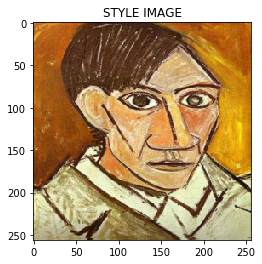

In [15]:
# read style image
sty_img = read_img('style_image.jpg')
sty_img = np.expand_dims(sty_img.astype(np.float32),axis=0)
 
# get style feature
styx = tf.constant(sty_img)
styx = tf_preprocess(styx)
style_fmap,_ = vgg19(styx)

# plot image
sty_img = np.squeeze(sty_img)
sty_img = visualize_img(sty_img)
plt.imshow(sty_img)
plt.title("STYLE IMAGE")
plt.show()

In [16]:
# preprocess for vgg net
cont_vgg_inps = tf_preprocess(inp_imgs)
transform_out2vgg = tf_preprocess(transform_out_img)

In [17]:
# content feature
_,cont_feat = vgg19(cont_vgg_inps) 

# connect transform net and vgg net
A,cont = vgg19(transform_out2vgg)

In [18]:
# style loss
E1 =tf.reduce_sum(tf.reduce_sum(tf.pow(A[0] - style_fmap[0], 2), 1), 1) /(64*64) 
E2 =tf.reduce_sum(tf.reduce_sum(tf.pow(A[1] - style_fmap[1], 2), 1), 1) /(128*128)
E3 =tf.reduce_sum(tf.reduce_sum(tf.pow(A[2] - style_fmap[2], 2), 1), 1) /(256*256)
E4 =tf.reduce_sum(tf.reduce_sum(tf.pow(A[3] - style_fmap[3], 2), 1), 1) /(512*512)
E5 =tf.reduce_sum(tf.reduce_sum(tf.pow(A[4] - style_fmap[4], 2), 1), 1) /(512*512)

# batch mean
E1 = tf.reduce_mean(E1)
E2 = tf.reduce_mean(E2)
E3 = tf.reduce_mean(E3)
E4 = tf.reduce_mean(E4)
E5 = tf.reduce_mean(E5)

# calc style loss
sty_loss =  E_W[0] * E1 +E_W[1] * E2 + E_W[2] * E3 +E_W[3] * E4 +E_W[4] * E5 


# content loss                
cont_loss = tf.reduce_sum(tf.reduce_sum(tf.pow(cont - cont_feat, 2), 1), 1) /(64*64*512)
# batch mean
cont_loss = tf.reduce_mean(cont_loss) 

# tv loss
tv_loss = tf.reduce_sum(tf.image.total_variation(transform_out_img))/ BATCH_SIZE

# total loss
total_loss = ALPHA*cont_loss + BETA*sty_loss + GAMMA*tv_loss

# optimizer
train_step = tf.train.AdamOptimizer(LR).minimize(total_loss)

### use instance norm, upsampling with resize, conv with mirror padding

ALPHA 1, BETA 5, GAMMA 1e-06
EPOCH : 0, STEP : 0, TIME : 0.0228224
total loss : 5.70741e+06, cont loss : 145559, sty loss : 1.11237e+06, tv loss : 1.64018e+07
input image => max : (253, 253, 253), min : (1, 1, 1), mean : (115.405, 112.787, 95.4136)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (138.638, 121.98, 129.234)


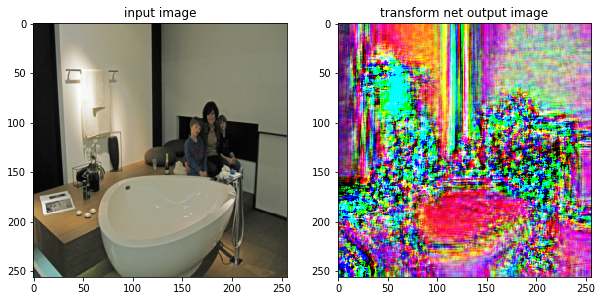

Model saved in file: model.ckpt
EPOCH : 0, STEP : 1000, TIME : 1371.81
total loss : 47237, cont loss : 27457.8, sty loss : 3955.13, tv loss : 3.60542e+06
input image => max : (255, 255, 255), min : (10, 12, 9), mean : (108.398, 106.91, 104.356)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (166.472, 126.657, 71.2926)


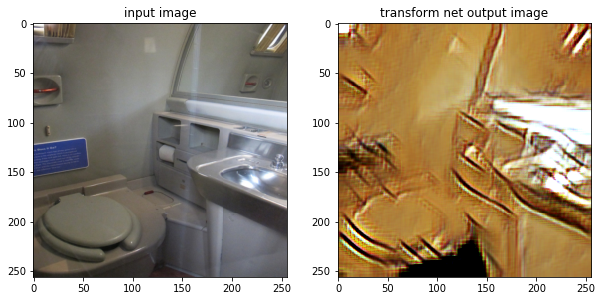

EPOCH : 0, STEP : 2000, TIME : 1369.34
total loss : 44448.5, cont loss : 27009.1, sty loss : 3487.05, tv loss : 4.14640e+06
input image => max : (249, 249, 254), min : (0, 1, 2), mean : (107.082, 126.516, 129.865)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (168.584, 126.843, 72.9206)


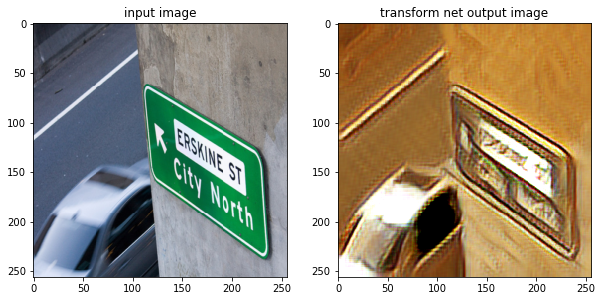

Model saved in file: model.ckpt
EPOCH : 0, STEP : 3000, TIME : 1371.24
total loss : 40073.5, cont loss : 29009, sty loss : 2212.1, tv loss : 4.06525e+06
input image => max : (227, 226, 225), min : (1, 1, 0), mean : (70.3081, 83.059, 86.2002)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (165.877, 125.685, 70.2603)


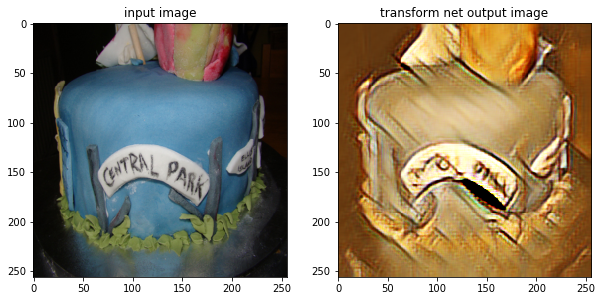

EPOCH : 0, STEP : 4000, TIME : 1370.61
total loss : 37749.3, cont loss : 26333.9, sty loss : 2282.22, tv loss : 4.24814e+06
input image => max : (254, 254, 254), min : (4, 3, 0), mean : (152.981, 126.926, 76.7473)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (166.692, 124.818, 68.9846)


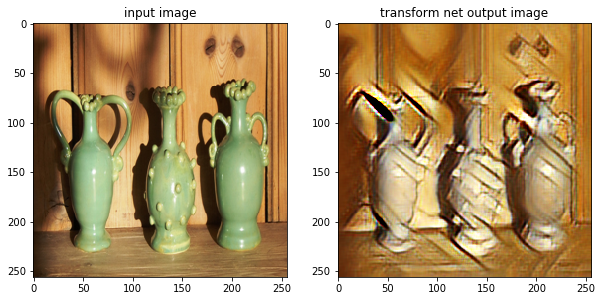

Model saved in file: model.ckpt
EPOCH : 0, STEP : 5000, TIME : 1372.74
total loss : 34045.1, cont loss : 25233, sty loss : 1761.57, tv loss : 4.2934e+06
input image => max : (255, 255, 255), min : (0, 0, 0), mean : (142.771, 121.859, 102.653)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (169.411, 128.215, 71.7653)


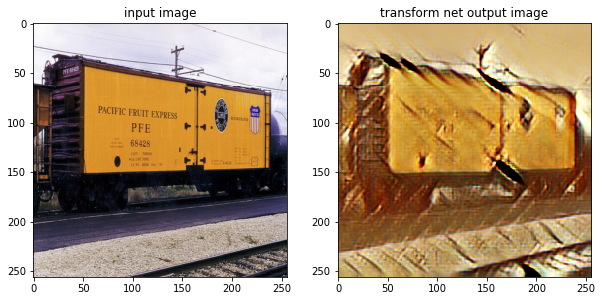

EPOCH : 1, STEP : 0, TIME : 0.0225999
total loss : 24005.7, cont loss : 16521.2, sty loss : 1496.02, tv loss : 4.36616e+06
input image => max : (253, 253, 253), min : (1, 1, 1), mean : (115.405, 112.787, 95.4136)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (168.084, 126.242, 69.3022)


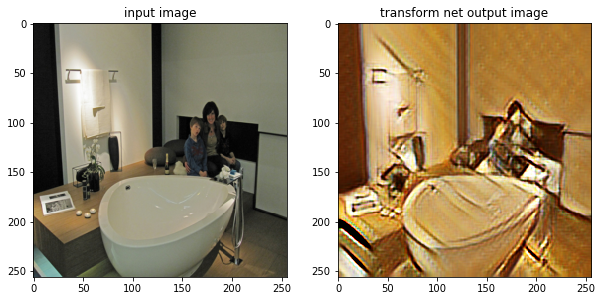

Model saved in file: model.ckpt
EPOCH : 1, STEP : 1000, TIME : 1320.26
total loss : 29502.7, cont loss : 19274.1, sty loss : 2044.91, tv loss : 4.0445e+06
input image => max : (255, 255, 255), min : (10, 12, 9), mean : (108.398, 106.91, 104.356)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (167.69, 125.462, 69.4891)


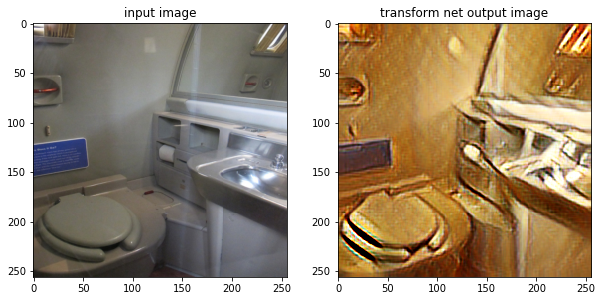

EPOCH : 1, STEP : 2000, TIME : 1319.95
total loss : 33264.1, cont loss : 22016.1, sty loss : 2248.75, tv loss : 4.28267e+06
input image => max : (249, 249, 254), min : (0, 1, 2), mean : (107.082, 126.516, 129.865)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (166.437, 125.422, 70.8172)


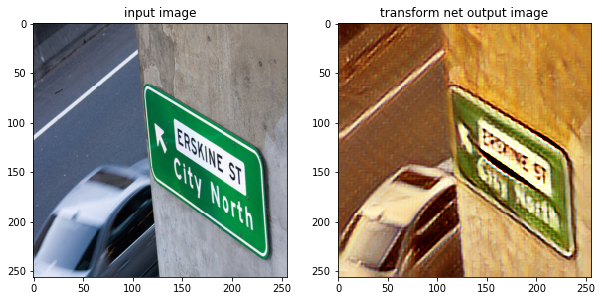

Model saved in file: model.ckpt
EPOCH : 1, STEP : 3000, TIME : 1320.04
total loss : 33096.1, cont loss : 25471.5, sty loss : 1524.05, tv loss : 4.32362e+06
input image => max : (227, 226, 225), min : (1, 1, 0), mean : (70.3081, 83.059, 86.2002)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (165.207, 124.573, 70.2164)


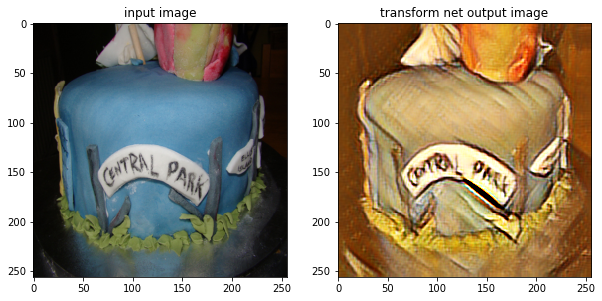

EPOCH : 1, STEP : 4000, TIME : 1319.89
total loss : 32737.2, cont loss : 23301.3, sty loss : 1886.33, tv loss : 4.20334e+06
input image => max : (254, 254, 254), min : (4, 3, 0), mean : (152.981, 126.926, 76.7473)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (168.529, 125.957, 70.451)


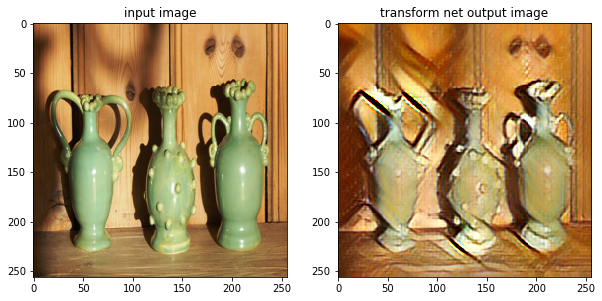

Model saved in file: model.ckpt
EPOCH : 1, STEP : 5000, TIME : 1320.28
total loss : 30326.1, cont loss : 22879.1, sty loss : 1488.56, tv loss : 4.14236e+06
input image => max : (255, 255, 255), min : (0, 0, 0), mean : (142.771, 121.859, 102.653)
transform net output => max : (255, 255, 255), min : (0, 0, 0), mean : (167.855, 125.966, 71.0867)


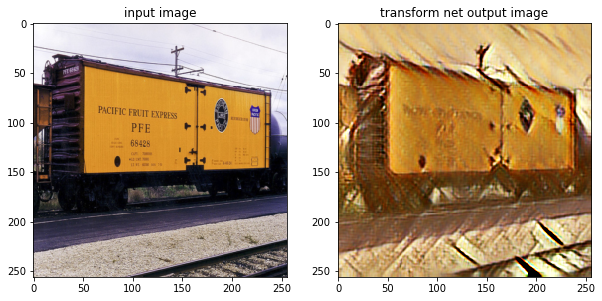

Model saved in file: model.ckpt


In [19]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
print("ALPHA %g, BETA %g, GAMMA %g"%(ALPHA, BETA, GAMMA))
saver = tf.train.Saver()
for epo in range(EPOCH):
    img_list = os.listdir(COCO_PATH)
    img_list = img_list[:DATA_NUM]
    step = 0 
    t1 = time.time()
    while img_list:
        
        # make batch images
        img_names = [img_list.pop() for _ in range(BATCH_SIZE)] # get image names
        batch_imgs = [read_img(COCO_PATH+img_name) for img_name in img_names] # read imges
        batch_imgs = np.stack([batch_imgs[i] for i in range(BATCH_SIZE)]) # stack, list to array :  B, H, W, C
        
        if step % 1000 == 0:
            t2 = time.time()
            print('EPOCH : %d, STEP : %d, TIME : %g'%(epo, step, t2-t1))
            t1 = t2
            tloss,closs,sloss,tvloss, tout = sess.run([total_loss,cont_loss,sty_loss,tv_loss,transform_out_img], feed_dict={inp_imgs:batch_imgs})
            print('total loss : %g, cont loss : %g, sty loss : %g, tv loss : %g'%(tloss,closs,sloss,tvloss))
            
            #
            plt.figure(figsize=(10,10))
            in_img = batch_imgs[0,:,:,:]
            in_img = visualize_img(in_img)
            print('input image => max : (%g, %g, %g), min : (%g, %g, %g), mean : (%g, %g, %g)'%(np.max(in_img[:,:,0]),np.max(in_img[:,:,1]),np.max(in_img[:,:,2])\
                                                                                                    ,np.min(in_img[:,:,0]),np.min(in_img[:,:,1]),np.min(in_img[:,:,2])\
                                                                                                    ,np.mean(in_img[:,:,0]),np.mean(in_img[:,:,1]),np.mean(in_img[:,:,2])))
            plt.subplot(121)
            plt.title("input image")
            plt.imshow(in_img)
            
            #
            tout = tout[0,:,:,:]
            tout = visualize_img(tout)
            print('transform net output => max : (%g, %g, %g), min : (%g, %g, %g), mean : (%g, %g, %g)'%(np.max(tout[:,:,0]),np.max(tout[:,:,1]),np.max(tout[:,:,2])\
                                                                                        ,np.min(tout[:,:,0]),np.min(tout[:,:,1]),np.min(tout[:,:,2])\
                                                                                        ,np.mean(tout[:,:,0]),np.mean(tout[:,:,1]),np.mean(tout[:,:,2])))
            plt.subplot(122)
            plt.title("transform net output image")
            plt.imshow(tout)
            
            plt.show()
            
        if step % 2000 == 0 :
            save_path = saver.save(sess, 'model.ckpt')
            print("Model saved in file: %s" % save_path)
        step += 1
        sess.run(train_step, feed_dict={inp_imgs: batch_imgs})

        
save_path = saver.save(sess, 'model.ckpt')
print("Model saved in file: %s" % save_path)

# model load

INFO:tensorflow:Restoring parameters from model.ckpt


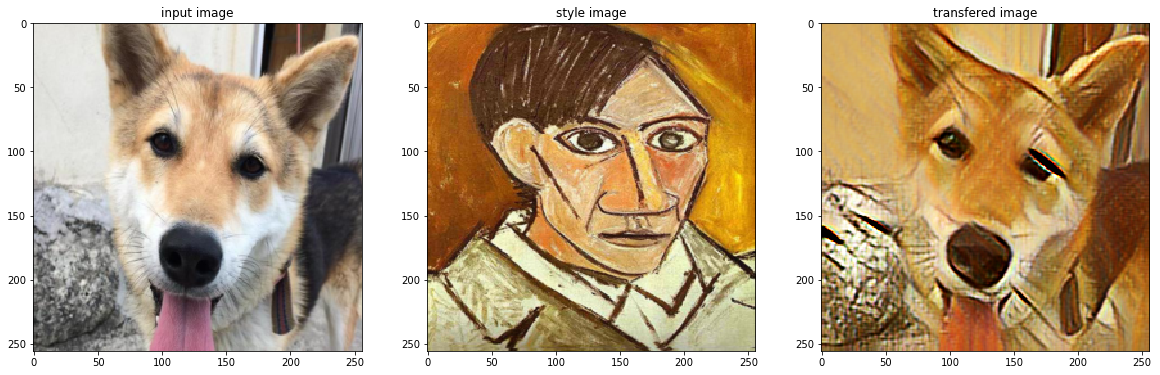

time :  0.09576582908630371


In [22]:
#### sess load
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'model.ckpt')
    test_img = read_img('content_image.jpg')
    test_img = np.expand_dims(test_img, axis=0)

    t1 = time.time()
    test_out = sess.run(transform_out_img, {inp_imgs:test_img})
    t2 = time.time()

    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(read_img('content_image.jpg'))
    plt.title('input image')

    plt.subplot(132)
    plt.imshow(read_img('style_image.jpg'))
    plt.title('style image')

    plt.subplot(133)
    plt.imshow(visualize_img(test_out[0,:,:,:]))
    plt.title('transfered image')
    plt.show()

    print('time : ',t2-t1)